### Import Libraries

In [1]:
# ===== Auto Reload =====
%load_ext autoreload
%autoreload 2

# ===== Standard Libraries =====
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import random

# ===== PyTorch =====
import torch
import torch.nn as nn
from torchdiffeq import odeint

# torchdiffeq 버전 확인
import torchdiffeq
print(f"torchdiffeq version: {torchdiffeq.__version__}")
print("")

# ===== Check Installation =====
print("="*50)
print("Environment Check")
print("="*50)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print(f"CUDA available: {torch.cuda.is_available()}")
print("="*50)
print("")


# ===== Your Custom Module =====
# Import from battery_ode_wrapper
from battery_ode_wrapper import*
from utils import*

print("="*50)
print("✓ All modules loaded!")
print("="*50)


torchdiffeq version: 0.2.5

Environment Check
PyTorch version: 2.5.1
CUDA device: NVIDIA RTX 3500 Ada Generation Laptop GPU
CUDA available: True

✓ All modules loaded!


### Data Import

In [2]:
import scipy.io
import os
import numpy as np
import re


# MATLAB 데이터 디렉토리 경로
data_dir = r"C:\Users\ljw76\Documents\MATLAB\LFP_SAFT\data\learning_data"

# ===== 온도 필터 설정 =====
target_temps = [25]  # 원하는 온도 리스트 (예: [25, 35] 또는 [] 이면 모든 온도)

# 디렉토리 내 모든 .mat 파일 목록 가져오기
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]
print(f"Found {len(mat_files)} .mat files:")
for file in mat_files:
    print(f"  - {file}")

# 모든 파일 로드
print(f"\nLoading files with temperature filter: {target_temps if target_temps else 'All'}")
all_loaded_data = {}

for i, file in enumerate(mat_files):
    file_path = os.path.join(data_dir, file)
    print(f"Loading {i+1}/{len(mat_files)}: {file}")
    
    try:
        mat_data = scipy.io.loadmat(file_path)
        
        # 온도 추출 (파일명에서, 대문자 C만 찾기)
        temp_match = re.search(r'_(\d+)C_', file)
        file_temp = int(temp_match.group(1)) if temp_match else None
        
        # 온도 필터링
        if target_temps and (file_temp is None or file_temp not in target_temps):
            print(f"  ⚠ Skipped (temp: {file_temp}°C)")
            continue
        
        # 파일명에서 확장자 제거하여 키로 사용
        file_key = file.replace('.mat', '')
        
        # 메타데이터 키 제외한 실제 데이터만 저장
        data_keys = [key for key in mat_data.keys() if not key.startswith('__')]
        all_loaded_data[file_key] = {}
        
        for key in data_keys:
            all_loaded_data[file_key][key] = mat_data[key]
        
        print(f"  ✓ Loaded (temp: {file_temp}°C) - {len(data_keys)} data keys: {data_keys}")
        
    except Exception as e:
        print(f"  ✗ Failed to load {file}: {e}")

print(f"\nAll files loaded!")
print(f"Successfully loaded {len(all_loaded_data)} files:")
for file_key, data_dict in all_loaded_data.items():
    print(f"  {file_key}: {list(data_dict.keys())}")

# 첫 번째 파일의 데이터 구조 상세 확인
if all_loaded_data:
    first_file_key = list(all_loaded_data.keys())[0]
    first_data_key = list(all_loaded_data[first_file_key].keys())[0]
    sample_data = all_loaded_data[first_file_key][first_data_key]

    print(f"\nSample data structure from {first_file_key}[{first_data_key}]:")
    print(f"  Shape: {sample_data.shape}")
    print(f"  Type: {type(sample_data)}")
    if hasattr(sample_data, 'dtype'):
        print(f"  Dtype: {sample_data.dtype}")
        if hasattr(sample_data.dtype, 'names') and sample_data.dtype.names:
            print(f"  Field names: {sample_data.dtype.names}")



Found 151 .mat files:
  - gitt_restonly_25C_SOC_10.mat
  - gitt_restonly_25C_SOC_100.mat
  - gitt_restonly_25C_SOC_11.mat
  - gitt_restonly_25C_SOC_12.mat
  - gitt_restonly_25C_SOC_13.mat
  - gitt_restonly_25C_SOC_14.mat
  - gitt_restonly_25C_SOC_15.mat
  - gitt_restonly_25C_SOC_16.mat
  - gitt_restonly_25C_SOC_17.mat
  - gitt_restonly_25C_SOC_18.mat
  - gitt_restonly_25C_SOC_19.mat
  - gitt_restonly_25C_SOC_2.mat
  - gitt_restonly_25C_SOC_20.mat
  - gitt_restonly_25C_SOC_21.mat
  - gitt_restonly_25C_SOC_22.mat
  - gitt_restonly_25C_SOC_23.mat
  - gitt_restonly_25C_SOC_25.mat
  - gitt_restonly_25C_SOC_26.mat
  - gitt_restonly_25C_SOC_27.mat
  - gitt_restonly_25C_SOC_28.mat
  - gitt_restonly_25C_SOC_29.mat
  - gitt_restonly_25C_SOC_3.mat
  - gitt_restonly_25C_SOC_30.mat
  - gitt_restonly_25C_SOC_31.mat
  - gitt_restonly_25C_SOC_32.mat
  - gitt_restonly_25C_SOC_33.mat
  - gitt_restonly_25C_SOC_34.mat
  - gitt_restonly_25C_SOC_35.mat
  - gitt_restonly_25C_SOC_36.mat
  - gitt_restonly_25C_

In [3]:
# ===== Key 선택 =====
target_keys = ["time", "Vref", "Vspme", "current", "temperature", "c_s_n_bulk", "soc_n", "ocp"]

# ===== 모든 파일 처리 =====
extracted_data = {}  # Dictionary로 저장

excluded_target = []
excluded_data = {}
# extracted_data는 excluded_target에 들어있지 않은 것만, excluded_data는 target에 들어있는 것만 저장하도록 아래 for문 수정

print("="*60)
print("Converting all structs to DataFrames")
print("="*60)

for file_key, data_dict in all_loaded_data.items():
    print(f"\nProcessing: {file_key}")
    
    # struct 추출 (첫 번째 key)
    struct_key = list(data_dict.keys())[0]
    struct_data = data_dict[struct_key]
    
    # DataFrame 변환
    df = struct_to_dataframe(struct_data, selected_keys=target_keys)

    # 저장: excluded_target 리스트에 있으면 excluded_data에, 아니면 extracted_data에
    if file_key in excluded_target:
        excluded_data[file_key] = df
        print(f"  ✓ DataFrame created (EXCLUDED): {df.shape}")
    else:
        extracted_data[file_key] = df
        print(f"  ✓ DataFrame created: {df.shape}")
    print(f"  Columns: {list(df.columns)}")

print("\n" + "="*60)
print(f"✓ Total {len(extracted_data)} DataFrames created!")
print(f"✓ Total {len(excluded_data)} EXCLUDED DataFrames created!")
print("="*60)

# 요약
for name, df in extracted_data.items():
    print(f"  {name}: {df.shape}")

for name, df in excluded_data.items():
    print(f"  (EXCLUDED) {name}: {df.shape}")
# extracted_data는 excluded_target에 들어있지 않은 것만 들어가게끔 for문에서 처리 (아래 for문 참고!)



Converting all structs to DataFrames

Processing: gitt_restonly_25C_SOC_10
Available keys in MATLAB struct:
   1. time
   2. current
   3. temperature
   4. Vout
   5. Ve
   6. Vcond
   7. eta_p
   8. eta_n
   9. Un
  10. Up
  11. ocp
  12. soc_n
  13. soc_p
  14. c_s_p_surf
  15. c_s_n_surf
  16. c_s_p_bulk
  17. c_s_n_bulk
  18. i0p
  19. k_cs
  20. alpha_cs
  21. tau_cs
  22. c_s_p_surf_tilde
  23. Dsn_eff
  24. Dsp_eff
  25. Vspme
  26. Vref
Total: 26 keys

Selected keys:
  1. time ✓
  2. Vref ✓
  3. Vspme ✓
  4. current ✓
  5. temperature ✓
  6. c_s_n_bulk ✓
  7. soc_n ✓
  8. ocp ✓

Extracting data:
------------------------------------------------------------
  ✓ time                : shape (3601, 1)       → 3601 points
  ✓ Vref                : shape (3601, 1)       → 3601 points
  ✓ Vspme               : shape (3601, 1)       → 3601 points
  ✓ current             : shape (3601, 1)       → 3601 points
  ✓ temperature         : shape (3601, 1)       → 3601 points
  ✓ c_s_n_bulk   

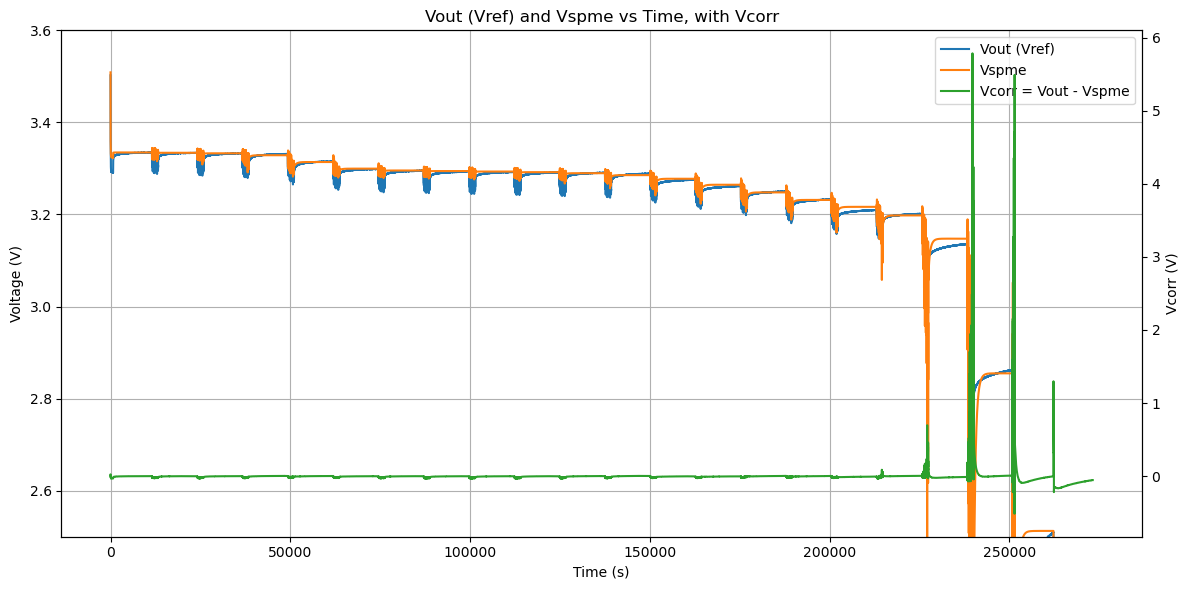

In [4]:
import matplotlib.pyplot as plt

df = extracted_data['udds2_1c_rest_25C_struct']

fig, ax1 = plt.subplots(figsize=(12,6))

# Left y-axis: Vout (Vref) and Vspme
ax1.plot(df['time'], df['Vref'], label='Vout (Vref)', color='C0')
ax1.plot(df['time'], df['Vspme'], label='Vspme', color='C1')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax1.set_ylim([2.5, 3.6])
ax1.set_title('Vout (Vref) and Vspme vs Time, with Vcorr')
ax1.grid(True)

# Right y-axis: Vcorr = Vout - Vspme
ax2 = ax1.twinx()
Vcorr = df['Vref'] - df['Vspme']
ax2.plot(df['time'], Vcorr, label='Vcorr = Vout - Vspme', color='C2')
ax2.set_ylabel('Vcorr (V)')
# Optionally, you may want to set Vcorr y-limits, e.g.:
# ax2.set_ylim([Vcorr.min(), Vcorr.max()])

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

fig.tight_layout()
plt.show()




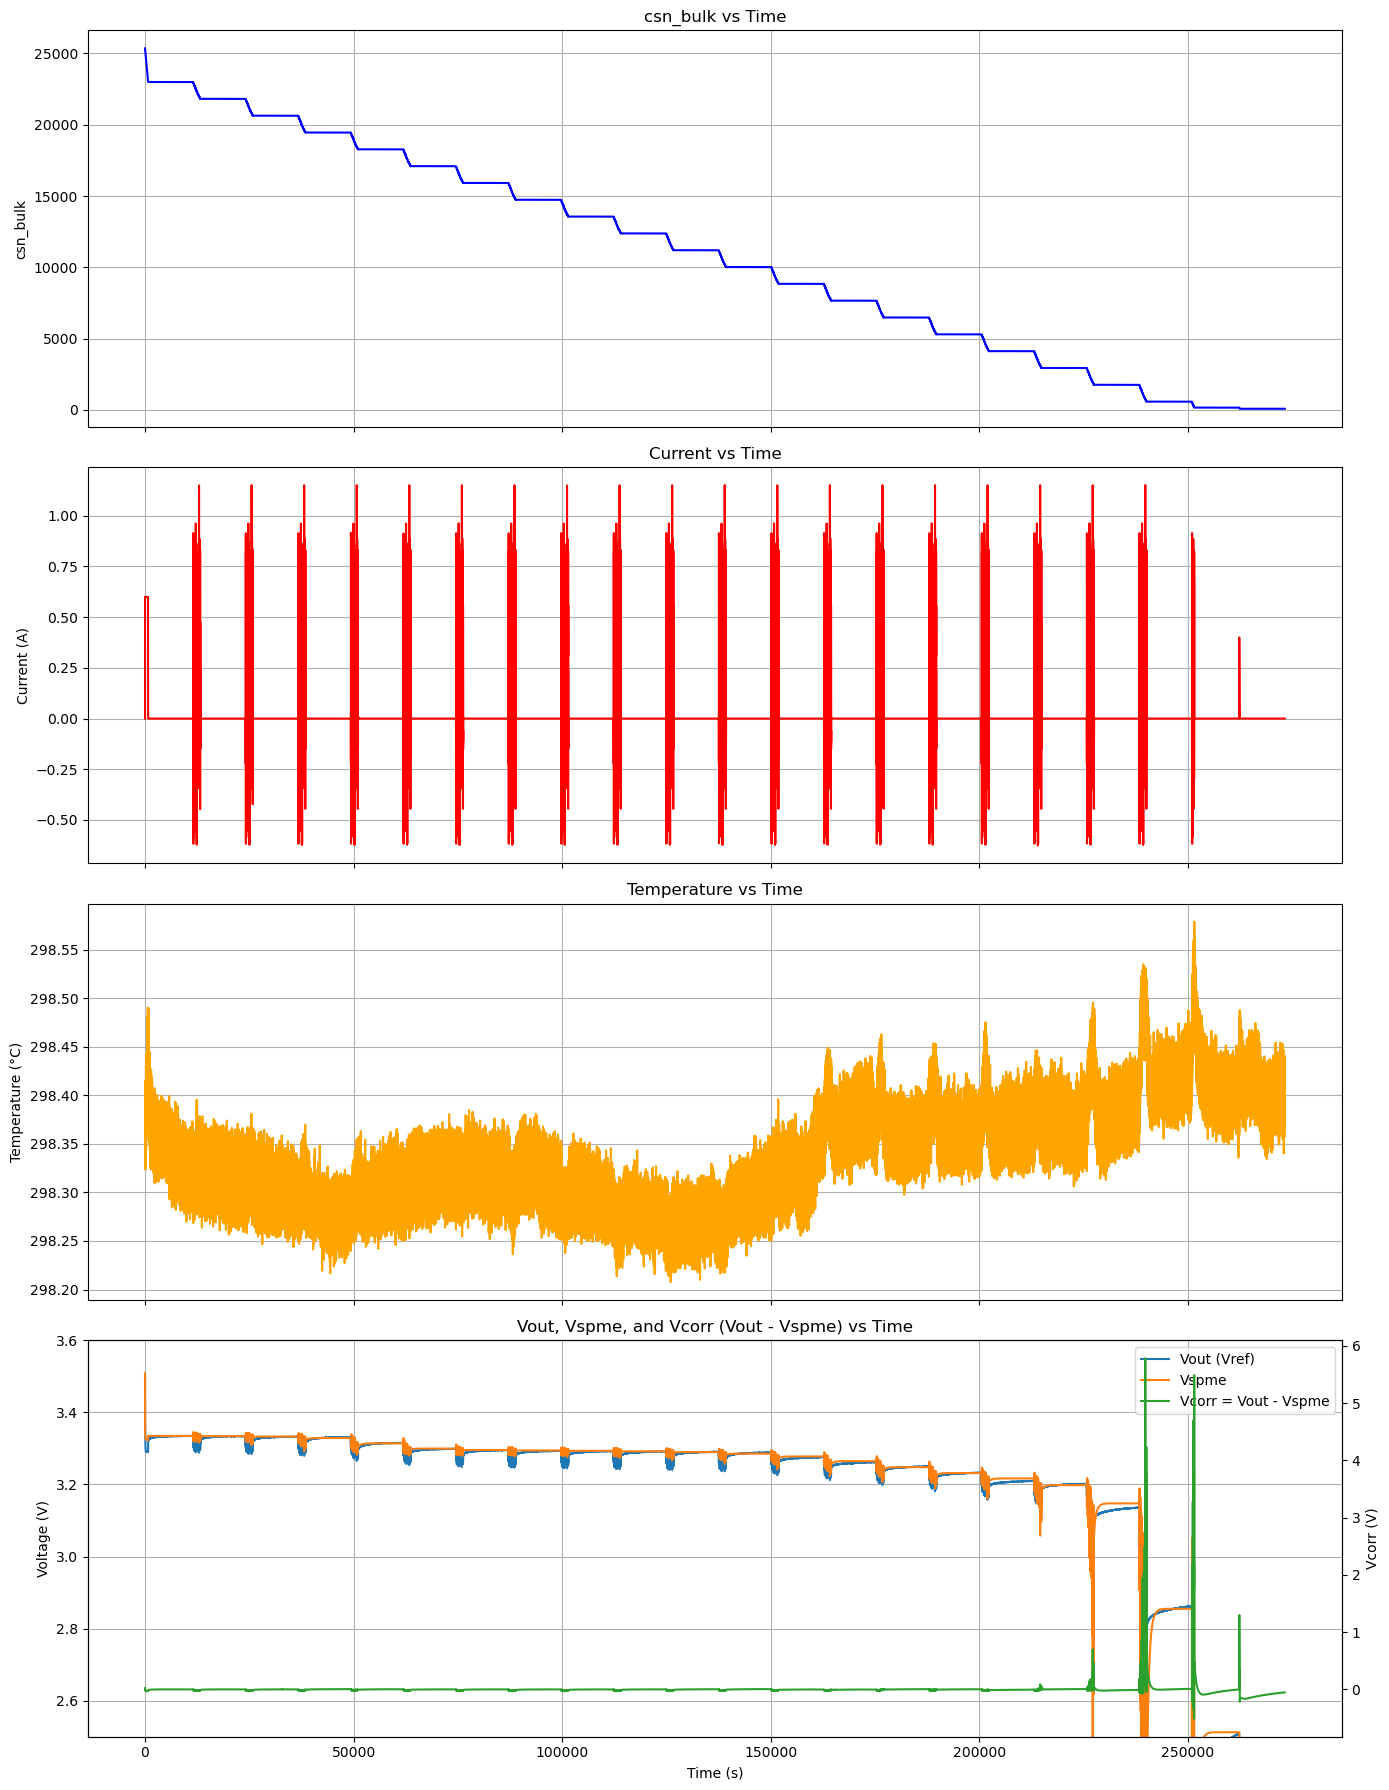

In [5]:
import matplotlib.pyplot as plt

# Assume df_sampled is already defined just as in the next cell (sampled first 10% of data)
df_vis = df

fig, axs = plt.subplots(4, 1, figsize=(14, 18), sharex=True)

# 1. csn_bulk
axs[0].plot(df_vis["time"], df_vis["c_s_n_bulk"], color="blue")
axs[0].set_ylabel("csn_bulk")
axs[0].set_title("csn_bulk vs Time")
axs[0].grid(True)

# 2. I (Current)
axs[1].plot(df_vis["time"], df_vis["current"], color="red")
axs[1].set_ylabel("Current (A)")
axs[1].set_title("Current vs Time")
axs[1].grid(True)

# 3. Temperature (T)
axs[2].plot(df_vis["time"], df_vis["temperature"], color="orange")
axs[2].set_ylabel("Temperature (°C)")
axs[2].set_title("Temperature vs Time")
axs[2].grid(True)

# 4. Vout, Vspme (left) and Vcorr (right)
ax4 = axs[3]
ax4.plot(df_vis["time"], df_vis["Vref"], label="Vout (Vref)", color="C0")
ax4.plot(df_vis["time"], df_vis["Vspme"], label="Vspme", color="C1")
ax4.set_ylabel("Voltage (V)")
ax4.set_title("Vout, Vspme, and Vcorr (Vout - Vspme) vs Time")
ax4.set_ylim([2.5, 3.6])  # Set voltage axis limits as requested
ax4.grid(True)

ax4r = ax4.twinx()
Vcorr = df_vis["Vref"] - df_vis["Vspme"]
ax4r.plot(df_vis["time"], Vcorr, label="Vcorr = Vout - Vspme", color="C2")
ax4r.set_ylabel("Vcorr (V)")

# Combine legends from both y-axes
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4r.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

axs[3].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()



In [ ]:
# Import the NEW clean implementation
from battery_ode_wrapper import train_battery_neural_ode
import pandas as pd
import re


# 'soc_n' 값이 0.96 ~ 0.12 (96% ~ 12%) 사이인 데이터만 target_data에 저장
# target_data를 리스트(list)로 저장 (DataFrame만 담김, key는 저장하지 않음)
target_keyword = ['restonly']
target_list = []
plt.figure(figsize=(12, 5))

# '정확히 들어있는' key만 골라야 한다.
# 즉, partial match는 안 되고, 부분 단어 단위(예: 'rest')가 key 중 'norest' 등에도 들어가 있으면 제외해야 한다.
# → "정확히 포함" = 'rest'라는 단어가 key에 있는데 앞뒤에 다른 알파벳(예: norest, unrest) 등이 붙어있으면 "rest"만 들어간 것이 아님 → 패턴 분리 필요
# 가장 명확한 건 '_'(언더바) 등으로 단어 구분된 구조에서 "단어 경계" 기준 매칭이다.
# 정규표현식으로 '[^a-zA-Z0-9]' + word + '[^a-zA-Z0-9]' 또는 key.split('_') 등으로 토큰화하여 비교



def match_exact_keywords(key, keywords):
    """
    key가 예: 'udds2_1c_rest_25C_struct' 같이 _로 나눠진 경우,
    keywords 중 하나라도 정확히 단어로써(key의 토큰) 포함되어야 True.
    """
    # 언더스코어 단위 분할
    tokens = re.split(r'[_\s]', key)
    # 모든 keywords가 이 토큰 list에 "정확히 단어로써" 존재하는가?
    return any(word in tokens for word in keywords)

target_list = []
print("extracted_data keys:")
for k in extracted_data.keys():
    print(" -", k)

found_any = False
for k, v in extracted_data.items():
    # 정확히 해당 단어가 분리된 토큰으로 존재하는지 확인
    keyword_match = match_exact_keywords(k, target_keyword)
    print(f"Key: {k}, keyword_match: {keyword_match}, type: {type(v)}")
    if keyword_match:
        if isinstance(v, dict):
            print("  Skipped (dict)")
            continue
        if hasattr(v, "columns") and ("soc_n" in v.columns) and ("Vref" in v.columns):
            mask = (v["soc_n"] >= 0.11) & (v["soc_n"] <= 0.96) & (v["Vref"] >= 2.5)
            filtered_df = v[mask].reset_index(drop=True)
            print(f"  Added! Rows: {len(filtered_df)}")
            target_list.append(filtered_df)
            found_any = True
        else:
            print("  Columns missing, skipped")
print(f"최종 target_list length: {len(target_list)}")
if not found_any:
    print("⚠️ 조건에 맞는 DataFrame이 없습니다. (key 토큰, 컬럼, 타입, 마스킹 등 모두 점검)")




rest_list = remove_duplicates(target_list)

rest_list_smooth = smooth_Vcorr(rest_list, 201) # de-noise data after downsampling

# rest_list_ds = downsample_df(rest_list_smooth, downsample_rate=1)   

rest_list_split = split_df(rest_list, window_minutes=20, time_col='time', random_seed=42)

rest_dict_list = df2dict(rest_list_split)

# 80:20 split for training and test
training_dict_list, test_dict_list = split_train_test(rest_dict_list, 0.8)



extracted_data keys:
 - gitt_restonly_25C_SOC_10
 - gitt_restonly_25C_SOC_100
 - gitt_restonly_25C_SOC_11
 - gitt_restonly_25C_SOC_12
 - gitt_restonly_25C_SOC_13
 - gitt_restonly_25C_SOC_14
 - gitt_restonly_25C_SOC_15
 - gitt_restonly_25C_SOC_16
 - gitt_restonly_25C_SOC_17
 - gitt_restonly_25C_SOC_18
 - gitt_restonly_25C_SOC_19
 - gitt_restonly_25C_SOC_2
 - gitt_restonly_25C_SOC_20
 - gitt_restonly_25C_SOC_21
 - gitt_restonly_25C_SOC_22
 - gitt_restonly_25C_SOC_23
 - gitt_restonly_25C_SOC_25
 - gitt_restonly_25C_SOC_26
 - gitt_restonly_25C_SOC_27
 - gitt_restonly_25C_SOC_28
 - gitt_restonly_25C_SOC_29
 - gitt_restonly_25C_SOC_3
 - gitt_restonly_25C_SOC_30
 - gitt_restonly_25C_SOC_31
 - gitt_restonly_25C_SOC_32
 - gitt_restonly_25C_SOC_33
 - gitt_restonly_25C_SOC_34
 - gitt_restonly_25C_SOC_35
 - gitt_restonly_25C_SOC_36
 - gitt_restonly_25C_SOC_37
 - gitt_restonly_25C_SOC_38
 - gitt_restonly_25C_SOC_39
 - gitt_restonly_25C_SOC_4
 - gitt_restonly_25C_SOC_40
 - gitt_restonly_25C_SOC_41
 

<Figure size 1200x500 with 0 Axes>

In [48]:
# Call training function
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_epochs = 3000  # Increased from 100 to 300
# lr = 5e-4  # Rest
lr = 5e-4  # Pulse


seed = 42 # 42 : Vcorr_k, csn_k, I_k, T_k,
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True



# 여러 프로파일 배치용 (training_dict_list 사용)
ode_wrapper, history = train_battery_neural_ode_batch(
    data_list=training_dict_list,
    num_epochs=num_epochs,
    lr=lr,
    device=device,
    verbose=True,
    training_batch_size=None,  # None이면 전체 한번에, 숫자면 그 개수만큼 랜덤 샘플링
    method='euler'
)


Batch Training: 27 total profiles
Training batch size: 27 profiles per epoch
Profile lengths: [901, 901, 901, 900, 901, 900, 899, 901, 900, 900, 900, 900, 900, 901, 901, 899, 900, 901, 900, 900, 901, 901, 899, 901, 901, 900, 901]
Time durations: ['899.0s', '899.0s', '899.0s', '899.0s', '900.0s', '899.0s', '898.0s', '900.0s', '899.0s', '898.0s', '899.0s', '899.0s', '899.0s', '899.0s', '899.0s', '898.0s', '898.0s', '899.0s', '899.0s', '899.0s', '899.0s', '899.0s', '898.0s', '899.0s', '900.0s', '899.0s', '899.0s']
Common time vector: [0, 900.0] with 901 points
✓ Batch inputs set: 27 profiles, 901 time steps

Neural Network Architecture
Sequential(
  (0): Linear(in_features=6, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): Tanh()
  (8): Linear(in_features=16, out_features=1, bias=True)
)


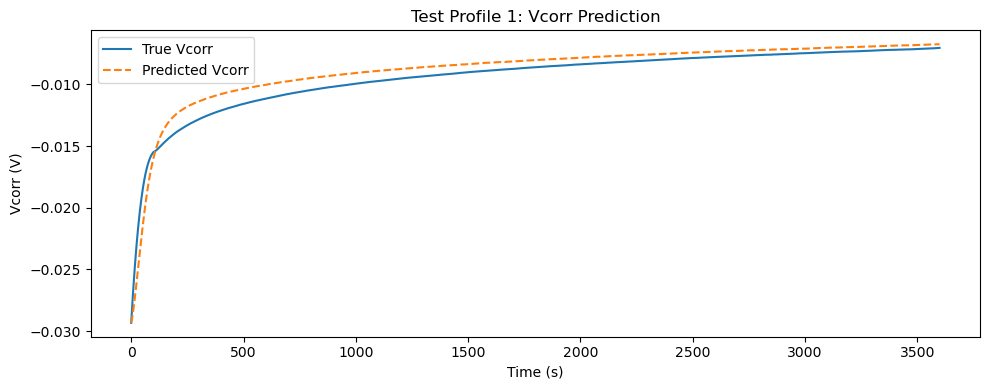

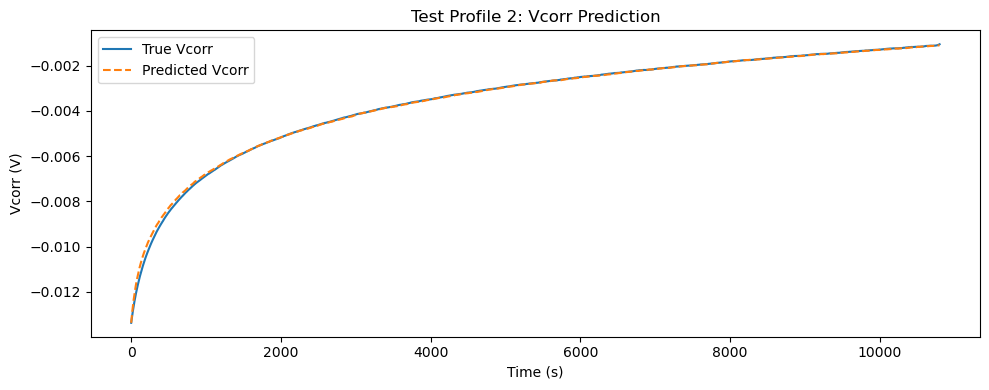

In [44]:
import torch
import numpy as np
import pandas as pd
from torchdiffeq import odeint
from battery_ode_wrapper import BatteryODEWrapper

# Load the trained model checkpoint
model_path = 'best_model_batch_rmse0.30mV.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model (BatteryODEWrapper only takes device parameter)
ode_wrapper_test = BatteryODEWrapper(device=device)
checkpoint = torch.load(model_path, map_location=device, weights_only=False)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    ode_wrapper_test.load_state_dict(checkpoint['model_state_dict'], strict=False)
else:
    ode_wrapper_test.load_state_dict(checkpoint, strict=False)
ode_wrapper_test.to(device)
ode_wrapper_test.eval()

# Run simulation on test data
test_results = []

for test_idx, test_data in enumerate(test_final_dict_list):
    # Set inputs for the wrapper
    ode_wrapper_test.set_inputs(test_data)
    
    # Prepare time and initial condition
    t = np.array(test_data['time'])
    t_tensor = torch.tensor(t, dtype=torch.float32, device=device)
    x0 = torch.tensor([[test_data['Y'][0]]], dtype=torch.float32, device=device)
    
    # Run simulation using odeint (NOT model.ode_solve)
    with torch.no_grad():
        sol = odeint(ode_wrapper_test, x0, t_tensor, method='euler')
        Vcorr_pred_norm = sol[:, 0, 0].cpu().numpy()
    
    # Denormalize Vcorr if needed
    if 'Y_std' in test_data and 'Y_mean' in test_data:
        Vcorr_pred = Vcorr_pred_norm * test_data['Y_std'] + test_data['Y_mean']
        Vcorr_true = np.array(test_data['Y']) * test_data['Y_std'] + test_data['Y_mean']
    else:
        Vcorr_pred = Vcorr_pred_norm
        Vcorr_true = np.array(test_data['Y'])
    
    test_results.append({
        'profile': test_idx,
        'time': t,
        'Vcorr_pred': Vcorr_pred,
        'Vcorr_true': Vcorr_true,
    })

# Display results
import matplotlib.pyplot as plt

for result in test_results:
    plt.figure(figsize=(10, 4))
    plt.plot(result['time'], result['Vcorr_true'], label='True Vcorr')
    plt.plot(result['time'], result['Vcorr_pred'], label='Predicted Vcorr', linestyle='--')
    plt.title(f"Test Profile {result['profile']+1}: Vcorr Prediction")
    plt.xlabel("Time (s)")
    plt.ylabel("Vcorr (V)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [51]:
# ===== Load checkpoint and run simulation with best_model_batch_rmse1.70mV.pth =====
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint
from battery_ode_wrapper import BatteryODEWrapper
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Normalization params (from utils.py lines 265-275)
csn_bulk_norm = 30555
current_norm = 0.1
temperature_norm = 10
temperature_mean = 298.15
Y_mean = -0.015
Y_std = 0.004
ocv_mean = 3.28  # 96 - 12 % SOC only
ocv_std = 0.04   # 96 - 12 % SOC only 
Vref_mean = 3.28 - 0.015
Vref_std = 0.04

def denorm_Y(Y_norm):
    return Y_norm * Y_std + Y_mean

def calc_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Load checkpoint
checkpoint_path = 'best_model_batch_rmse1.83mV_6input_euler.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Loading checkpoint from: {checkpoint_path}")
ode_wrapper_test = BatteryODEWrapper(device=device)
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    ode_wrapper_test.load_state_dict(checkpoint['model_state_dict'], strict=False)
    training_info = checkpoint.get('training_info', {})
    print(f"✓ Checkpoint loaded successfully!")
    if training_info:
        print(f"  - Best RMSE: {training_info.get('best_rmse', 'N/A'):.2f}mV")
        print(f"  - Best epoch: {training_info.get('best_epoch', 'N/A')}")
else:
    ode_wrapper_test.load_state_dict(checkpoint, strict=False)
    print(f"✓ Checkpoint loaded successfully! (legacy format)")

ode_wrapper_test.to(device)
ode_wrapper_test.eval()

# ----- 1. Run simulation (배치) on test_dict_list -----
# 배치 inference (run NeuralODE for each dict)
test_sim_results = []
for idx, d in enumerate(test_dict_list):
    # 시뮬레이션 준비
    t = np.array(d['time'])
    t_tensor = torch.tensor(t, dtype=torch.float32, device=device)
    x0 = torch.tensor([[d['Y'][0]]], dtype=torch.float32, device=device)  # normalized Y
    
    # 입력 셋팅
    ode_wrapper_test.set_inputs(d)

    # 시뮬레이션
    with torch.no_grad():
        sol = odeint(ode_wrapper_test, x0, t_tensor, method='euler')
        Y_pred = sol[:, 0, 0].cpu().numpy()  # normalized
    test_sim_results.append(Y_pred)
    
# 'Y_pred'를 test_dict_list 각 dict에 넣어줌
for idx, d in enumerate(test_dict_list):
    d['Y_pred'] = test_sim_results[idx]  # normalized

# ----- 2. 각 dict 사용한 rmse 값 프린트 -----
rmse_values = []
mask_soc_range = []

for idx, d in enumerate(test_dict_list):
    # Denormalize Y (Vcorr)
    Y_pred_denorm = denorm_Y(np.array(d['Y_pred']))
    Y_true_denorm = denorm_Y(np.array(d['Y']))  # ground truth

    rmse = calc_rmse(Y_true_denorm, Y_pred_denorm)
    rmse_values.append(rmse)
    
    # SOC 마스킹 (0.11~0.96)
    soc = np.array(d['SOC'])
    mask = (soc >= 0.11) & (soc <= 0.96)
    mask_soc_range.append(mask)

    print(f"Test Dict {idx}: RMSE = {rmse * 1e3:.3f} mV (all points), "
          f"RMSE_in_SOC[0.11, 0.96] = {calc_rmse(Y_true_denorm[mask], Y_pred_denorm[mask]) * 1e3:.3f} mV "
          f"[points: {mask.sum()}]")

# 3. soc [0.11, 0.96] 사이 값들의 최소, median, 최대 RMSE dict의 전압값 프린트

rmse_soc_range = [
    calc_rmse(denorm_Y(np.array(d['Y'])[mask_soc_range[idx]]), denorm_Y(np.array(d['Y_pred'])[mask_soc_range[idx]]))
    for idx, d in enumerate(test_dict_list)
]
rmse_soc_range = np.array(rmse_soc_range)

# min, median, max 찾기
args_sorted = np.argsort(rmse_soc_range)
idx_min = args_sorted[0]
idx_median = args_sorted[len(rmse_soc_range) // 2]
idx_max = args_sorted[-1]

highlight_indices = [("min", idx_min), ("median", idx_median), ("max", idx_max)]

for label, idx in highlight_indices:
    d = test_dict_list[idx]
    mask = mask_soc_range[idx]

    V_meas = np.array(d['V_meas'])[mask]
    V_spme = np.array(d['V_spme'])[mask]
    Y_pred_d = denorm_Y(np.array(d['Y_pred']))[mask]
    SOC = np.array(d['SOC'])[mask]
    time = np.array(d['time'])[mask]

    # Create subplot with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Left y-axis: Voltage
    fig.add_trace(
        go.Scatter(x=time, y=V_meas, name='V_meas', line=dict(color='blue', width=2)),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=time, y=V_spme + Y_pred_d, name='V_spme + Y_pred (denorm)', 
                  line=dict(color='red', width=2, dash='dash')),
        secondary_y=False,
    )
    
    # Right y-axis: SOC
    fig.add_trace(
        go.Scatter(x=time, y=SOC, name='SOC', line=dict(color='green', width=2, dash='dot')),
        secondary_y=True,
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Time (s)")
    fig.update_yaxes(title_text="Voltage (V)", secondary_y=False)
    fig.update_yaxes(title_text="SOC", secondary_y=True)
    
    # Update title
    fig.update_layout(
        title=f'Test Dict #{idx} ({label.upper()} RMSE in SOC[0.11,0.96]) | RMSE: {rmse_soc_range[idx]*1e3:.3f} mV',
        width=1000,
        height=500
    )
    
    fig.show()



Loading checkpoint from: best_model_batch_rmse1.83mV_6input_euler.pth
✓ Checkpoint loaded successfully!
  - Best RMSE: 1.83mV
  - Best epoch: 1000
Test Dict 0: RMSE = 0.834 mV (all points), RMSE_in_SOC[0.11, 0.96] = 0.834 mV [points: 901]
Test Dict 1: RMSE = 2.334 mV (all points), RMSE_in_SOC[0.11, 0.96] = 2.334 mV [points: 901]
Test Dict 2: RMSE = 1.269 mV (all points), RMSE_in_SOC[0.11, 0.96] = 1.269 mV [points: 901]
Test Dict 3: RMSE = 0.763 mV (all points), RMSE_in_SOC[0.11, 0.96] = 0.763 mV [points: 900]
Test Dict 4: RMSE = 1.124 mV (all points), RMSE_in_SOC[0.11, 0.96] = 1.124 mV [points: 901]
Test Dict 5: RMSE = 2.140 mV (all points), RMSE_in_SOC[0.11, 0.96] = 2.140 mV [points: 900]
Test Dict 6: RMSE = 1.352 mV (all points), RMSE_in_SOC[0.11, 0.96] = 1.352 mV [points: 900]


In [60]:
# ===== Transfer Learning: Load checkpoint and continue training =====
import torch
from battery_ode_wrapper import BatteryODEWrapper, train_battery_neural_ode_batch

# Load checkpoint
checkpoint_path = 'best_model_batch_rmse1.61mV_driving_6input.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*60)
print(f"Loading checkpoint for transfer learning: {checkpoint_path}")
print("="*60)

checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

# Create model and load weights
ode_wrapper_pretrained = BatteryODEWrapper(device=device)

if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    ode_wrapper_pretrained.load_state_dict(checkpoint['model_state_dict'], strict=False)
    training_info = checkpoint.get('training_info', {})
    print(f"✓ Checkpoint loaded successfully!")
    if training_info:
        print(f"  Previous training info:")
        print(f"  - Best RMSE: {training_info.get('best_rmse', 'N/A'):.2f}mV")
        print(f"  - Best epoch: {training_info.get('best_epoch', 'N/A')}")
        print(f"  - Total epochs: {training_info.get('total_epochs', 'N/A')}")
        print(f"  - Alpha: {training_info.get('alpha', 'N/A')}, Beta: {training_info.get('beta', 'N/A')}, Gamma: {training_info.get('gamma', 'N/A')}")
        print(f"  - Initial LR: {training_info.get('initial_lr', 'N/A')}")
        print(f"  - Method: {training_info.get('method', 'N/A')}")
else:
    ode_wrapper_pretrained.load_state_dict(checkpoint, strict=False)
    print(f"✓ Checkpoint loaded successfully! (legacy format)")

ode_wrapper_pretrained.to(device)
ode_wrapper_pretrained.eval()

print("\n" + "="*60)
print("Starting transfer learning (continued training)...")
print("="*60)

# Continue training with existing training_dict_list
# Adjust these parameters as needed
num_epochs_continued = 50  # Additional epochs to train
lr_continued = 1e-4  # Learning rate (can be lower for fine-tuning)
training_batch_size = None  # Use all profiles, or set a number

ode_wrapper_continued, history_continued = train_battery_neural_ode_batch(
    data_list=training_dict_list,
    num_epochs=num_epochs_continued,
    lr=lr_continued,
    device=device,
    verbose=True,
    training_batch_size=training_batch_size,
    ode_wrapper=ode_wrapper_pretrained,  # Pass the pretrained model
    method='euler'
)

print("\n" + "="*60)
print("Transfer learning completed!")
print("="*60)



Loading checkpoint for transfer learning: best_model_batch_rmse1.61mV_driving_6input.pth
✓ Checkpoint loaded successfully!
  Previous training info:
  - Best RMSE: 1.61mV
  - Best epoch: 1343
  - Total epochs: 3000
  - Alpha: 1, Beta: 0, Gamma: 0
  - Initial LR: 0.0005
  - Method: euler

Starting transfer learning (continued training)...

Batch Training: 204 total profiles
Training batch size: 204 profiles per epoch
Profile lengths: [1203, 1202, 1202, 1203, 1201, 1203, 1204, 1204, 1202, 1201, 1203, 1202, 1200, 1202, 1201, 1201, 1204, 1202, 1200, 1202, 1202, 1204, 1200, 1204, 1201, 1201, 1202, 1201, 1202, 1204, 1203, 1202, 1203, 1204, 1201, 1201, 1201, 1201, 1200, 1200, 1204, 1202, 1200, 1203, 1201, 1201, 1201, 1200, 1204, 1204, 1203, 1200, 1201, 1200, 1201, 1202, 1201, 1201, 1201, 1202, 1201, 1202, 1202, 1201, 1202, 1203, 1201, 1204, 1202, 1200, 1203, 1201, 1201, 1202, 1202, 1202, 1200, 1202, 1201, 1201, 1203, 1201, 1201, 1202, 1202, 1201, 1203, 1204, 1201, 1203, 1202, 1202, 1202, 1201

In [61]:
# ===== Load checkpoint and run simulation with best_model_batch_rmse1.70mV.pth =====
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint
from battery_ode_wrapper import BatteryODEWrapper
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Normalization params (from utils.py lines 265-275)
csn_bulk_norm = 30555
current_norm = 0.1
temperature_norm = 10
temperature_mean = 298.15
Y_mean = -0.015
Y_std = 0.004
ocv_mean = 3.28  # 96 - 12 % SOC only
ocv_std = 0.04   # 96 - 12 % SOC only 
Vref_mean = 3.28 - 0.015
Vref_std = 0.04

def denorm_Y(Y_norm):
    return Y_norm * Y_std + Y_mean

def calc_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Load checkpoint
checkpoint_path = 'best_model_batch_rmse1.82mV.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Loading checkpoint from: {checkpoint_path}")
ode_wrapper_test = BatteryODEWrapper(device=device)
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    ode_wrapper_test.load_state_dict(checkpoint['model_state_dict'], strict=False)
    training_info = checkpoint.get('training_info', {})
    print(f"✓ Checkpoint loaded successfully!")
    if training_info:
        print(f"  - Best RMSE: {training_info.get('best_rmse', 'N/A'):.2f}mV")
        print(f"  - Best epoch: {training_info.get('best_epoch', 'N/A')}")
else:
    ode_wrapper_test.load_state_dict(checkpoint, strict=False)
    print(f"✓ Checkpoint loaded successfully! (legacy format)")

ode_wrapper_test.to(device)
ode_wrapper_test.eval()

# ----- 1. Run simulation (배치) on test_dict_list -----
# 배치 inference (run NeuralODE for each dict)
test_sim_results = []
for idx, d in enumerate(test_dict_list):
    # 시뮬레이션 준비
    t = np.array(d['time'])
    t_tensor = torch.tensor(t, dtype=torch.float32, device=device)
    x0 = torch.tensor([[d['Y'][0]]], dtype=torch.float32, device=device)  # normalized Y
    
    # 입력 셋팅
    ode_wrapper_test.set_inputs(d)

    # 시뮬레이션
    with torch.no_grad():
        sol = odeint(ode_wrapper_test, x0, t_tensor, method='euler')
        Y_pred = sol[:, 0, 0].cpu().numpy()  # normalized
    test_sim_results.append(Y_pred)
    
# 'Y_pred'를 test_dict_list 각 dict에 넣어줌
for idx, d in enumerate(test_dict_list):
    d['Y_pred'] = test_sim_results[idx]  # normalized

# ----- 2. 각 dict 사용한 rmse 값 프린트 -----
rmse_values = []
mask_soc_range = []

for idx, d in enumerate(test_dict_list):
    # Denormalize Y (Vcorr)
    Y_pred_denorm = denorm_Y(np.array(d['Y_pred']))
    Y_true_denorm = denorm_Y(np.array(d['Y']))  # ground truth

    rmse = calc_rmse(Y_true_denorm, Y_pred_denorm)
    rmse_values.append(rmse)
    
    # SOC 마스킹 (0.11~0.96)
    soc = np.array(d['SOC'])
    mask = (soc >= 0.11) & (soc <= 0.96)
    mask_soc_range.append(mask)

    print(f"Test Dict {idx}: RMSE = {rmse * 1e3:.3f} mV (all points), "
          f"RMSE_in_SOC[0.11, 0.96] = {calc_rmse(Y_true_denorm[mask], Y_pred_denorm[mask]) * 1e3:.3f} mV "
          f"[points: {mask.sum()}]")

# 3. soc [0.11, 0.96] 사이 값들의 최소, median, 최대 RMSE dict의 전압값 프린트

rmse_soc_range = [
    calc_rmse(denorm_Y(np.array(d['Y'])[mask_soc_range[idx]]), denorm_Y(np.array(d['Y_pred'])[mask_soc_range[idx]]))
    for idx, d in enumerate(test_dict_list)
]
rmse_soc_range = np.array(rmse_soc_range)

# min, median, max 찾기
args_sorted = np.argsort(rmse_soc_range)
idx_min = args_sorted[0]
idx_median = args_sorted[len(rmse_soc_range) // 2]
idx_max = args_sorted[-1]

highlight_indices = [("min", idx_min), ("median", idx_median), ("max", idx_max)]

for label, idx in highlight_indices:
    d = test_dict_list[idx]
    mask = mask_soc_range[idx]

    V_meas = np.array(d['V_meas'])[mask]
    V_spme = np.array(d['V_spme'])[mask]
    Y_pred_d = denorm_Y(np.array(d['Y_pred']))[mask]
    SOC = np.array(d['SOC'])[mask]
    time = np.array(d['time'])[mask]

    # Create subplot with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Left y-axis: Voltage
    fig.add_trace(
        go.Scatter(x=time, y=V_meas, name='V_meas', line=dict(color='blue', width=2)),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=time, y=V_spme + Y_pred_d, name='V_spme + Y_pred (denorm)', 
                  line=dict(color='red', width=2, dash='dash')),
        secondary_y=False,
    )
    
    # Right y-axis: SOC
    fig.add_trace(
        go.Scatter(x=time, y=SOC, name='SOC', line=dict(color='green', width=2, dash='dot')),
        secondary_y=True,
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Time (s)")
    fig.update_yaxes(title_text="Voltage (V)", secondary_y=False)
    fig.update_yaxes(title_text="SOC", secondary_y=True)
    
    # Update title
    fig.update_layout(
        title=f'Test Dict #{idx} ({label.upper()} RMSE in SOC[0.11,0.96]) | RMSE: {rmse_soc_range[idx]*1e3:.3f} mV',
        width=1000,
        height=500
    )
    
    fig.show()



Loading checkpoint from: best_model_batch_rmse1.82mV.pth
✓ Checkpoint loaded successfully!
  - Best RMSE: 1.82mV
  - Best epoch: 50
Test Dict 0: RMSE = 2.720 mV (all points), RMSE_in_SOC[0.11, 0.96] = 2.720 mV [points: 1201]
Test Dict 1: RMSE = 0.532 mV (all points), RMSE_in_SOC[0.11, 0.96] = 0.532 mV [points: 1201]
Test Dict 2: RMSE = 1.010 mV (all points), RMSE_in_SOC[0.11, 0.96] = 1.010 mV [points: 1202]
Test Dict 3: RMSE = 0.612 mV (all points), RMSE_in_SOC[0.11, 0.96] = 0.612 mV [points: 1201]
Test Dict 4: RMSE = 0.745 mV (all points), RMSE_in_SOC[0.11, 0.96] = 0.745 mV [points: 1202]
Test Dict 5: RMSE = 2.434 mV (all points), RMSE_in_SOC[0.11, 0.96] = 2.434 mV [points: 1204]
Test Dict 6: RMSE = 0.961 mV (all points), RMSE_in_SOC[0.11, 0.96] = 0.961 mV [points: 1202]
Test Dict 7: RMSE = 9.448 mV (all points), RMSE_in_SOC[0.11, 0.96] = 9.448 mV [points: 1203]
Test Dict 8: RMSE = 0.839 mV (all points), RMSE_in_SOC[0.11, 0.96] = 0.839 mV [points: 1203]
Test Dict 9: RMSE = 1.482 mV (a